In [41]:
import pandas as pd
import numpy as np

## Read data

In [42]:
filelist = ['BH']

df = pd.read_csv('2021/BH.csv')
print(df.shape)
df.head()

(8760, 16)


,year,month,day,hour,Dn,Dm,Dx,Sn,Sm,Sx,Ta,Ua,Pa,Rc,Rd,Ri
0,2021.0,1.0,1.0,0.0,36.05,47.48,65.57,7.21,9.63,11.41,2.91,49.57,828.14,655.35,43840.0,0.0
1,2021.0,1.0,1.0,1.0,34.22,43.85,81.98,7.17,10.59,12.95,2.99,47.38,827.86,655.35,43840.0,0.0
2,2021.0,1.0,1.0,2.0,31.73,43.43,69.63,7.40,11.56,14.18,2.86,47.86,827.76,655.35,43840.0,0.0
3,2021.0,1.0,1.0,3.0,28.95,42.53,65.62,6.23,9.55,11.80,2.63,48.15,828.01,655.35,43840.0,0.0
4,2021.0,1.0,1.0,4.0,31.20,42.15,54.13,8.34,11.30,13.12,2.34,49.36,828.20,655.35,43840.0,0.0


<AxesSubplot:>

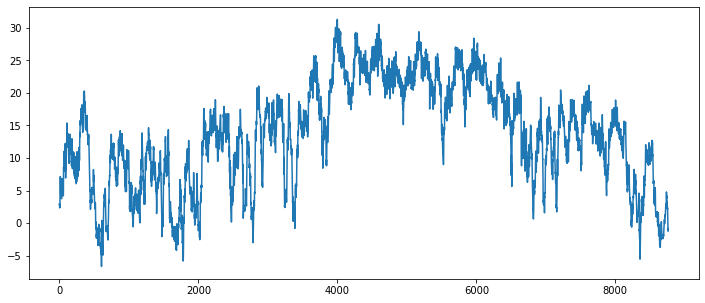

In [43]:
df['Ta'].plot(figsize=(12,5))

## Check for stationarity (p-value should be less than 0.05)

In [44]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)
        
adf_test(np.nan_to_num(df['Ta'], nan=0.0))
adf_test(np.nan_to_num(df['Ua'], nan=0.0))

1. ADF :  -4.047757553720018
2. P-Value :  0.0011800823296010373
3. Num Of Lags :  37
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 8722
5. Critical Values :
	 1% :  -3.431099968539641
	 5% :  -2.86187143613454
	 10% :  -2.5669464184887825
1. ADF :  -8.744605390618174
2. P-Value :  2.9458476665525606e-14
3. Num Of Lags :  27
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 8732
5. Critical Values :
	 1% :  -3.4310991094132306
	 5% :  -2.8618710565057626
	 10% :  -2.5669462164097956


## Figure out order for ARIMA model

In [45]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(np.nan_to_num(df['Ta'], nan=0.0), 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8760
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -9206.594
Date:                Sun, 17 Apr 2022   AIC                          18423.188
Time:                        22:52:15   BIC                          18458.577
Sample:                             0   HQIC                         18435.247
                               - 8760                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0598      0.046     22.810      0.000       0.969       1.151
ar.L2         -0.1564      0.011    -13.744      0.000      -0.179      -0.134
ar.L3         -0.0257      0.009     -3.010      0.003      -0.042      -0.009
ma.L1         -0.8775      0.047    -18.713      0.000      -0.969      -0.786
sigma2         0.4792      0.002    254.463      0.000       0.475       0.483
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1666920.66
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        70.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Split Data into Training and Testing

In [46]:
test_samples_num = int(0.1 * df.shape[0])
train = df.iloc[:-test_samples_num]
test = df.iloc[-test_samples_num:]
print(train.shape, test.shape)
print(test.iloc[0], test.iloc[-1])

(7884, 16) (876, 16)
year      2021.00
month       11.00
day         25.00
hour        12.00
Dn          59.77
Dm          63.58
Dx         141.02
Sn           3.90
Sm           7.49
Sx          10.16
Ta           8.24
Ua          11.07
Pa         836.49
Rc         144.20
Rd       14480.00
Ri           0.00
Name: 7884, dtype: float64 year     2021.00
month      12.00
day        31.00
hour       23.00
Dn        191.86
Dm        200.78
Dx        214.12
Sn          4.78
Sm          5.54
Sx          6.15
Ta         -0.84
Ua         91.71
Pa        823.39
Rc        449.18
Rd       6080.00
Ri          0.00
Name: 8759, dtype: float64


## Train the ARIMA model

In [47]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(np.nan_to_num(train['Ta'], nan=0.0), order=(3, 1, 1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7884
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -8483.967
Date:                Sun, 17 Apr 2022   AIC                          16977.935
Time:                        22:52:17   BIC                          17012.797
Sample:                             0   HQIC                         16989.876
                               - 7884                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0495      0.048     21.736      0.000       0.955       1.144
ar.L2         -0.1485      0.012    -12.637      0.000      -0.172      -0.125
ar.L3         -0.0271      0.009     -2.957      0.003      -0.045      -0.009
ma.L1         -0.8757      0.049    -17.970      0.000      -0.971      -0.780
sigma2         0.5039      0.002    240.469      0.000       0.500       0.508
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1456954.90
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        69.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Make predictions on test set

<AxesSubplot:>

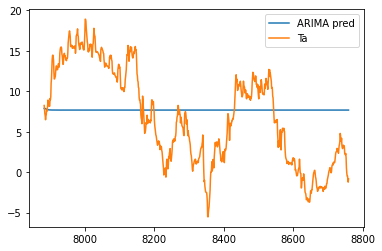

In [52]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start,end=end,typ='levels')
pred = pd.DataFrame(pred, columns=['ARIMA pred'], index=np.arange(start, end+1))
pred.plot(legend=True)
test['Ta'].plot(legend=True)